<a href="https://colab.research.google.com/github/vhrique/aerogerador_fault_diagnosis/blob/main/baseline_experiment_pareto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pymoo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.4/68.4 kB 611.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 10.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.8 MB/s eta 0:00:00
  Created wheel for grapheme: filename=grapheme-0.6.0-py3-none-any.whl size=210082 sha256=a8592a50cfd521da90d031781e0f526b08ee486473bd05998ce0b0282bfccba8
  Stored in directory: /root/.cache/pip/wheels/01/e1/49/37e6bde9886439057450c494a79b0bef8bbe897a54aebfc757
Successfully built grapheme


In [64]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.core.problem import Problem
from pymoo.decomposition.asf import ASF
from pymoo.optimize import minimize
from pymoo.termination import get_termination
from pymoo.util.ref_dirs import get_reference_directions

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import OrdinalEncoder

# Load Data

In [4]:
# Copy the files to your Google Drive and set your paths here
df_features = pd.read_csv('/content/drive/MyDrive/Estudos/Datasets/pas_aerogerador_helon/X10.csv', header=None)
df_labels = pd.read_csv('/content/drive/MyDrive/Estudos/Datasets/pas_aerogerador_helon/y_case2.csv', header=None)

In [5]:
X = df_features.to_numpy()
y = df_labels.to_numpy().squeeze()

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

# RandomForest Experiment

In [53]:
mdl = RandomForestClassifier(max_samples=0.5).fit(X_train, y_train)
y_pred = mdl.predict(X_test)


In [54]:
print(
    classification_report(
        y_test, y_pred
    )
)

              precision    recall  f1-score   support

         0.0       0.93      0.94      0.93        67
         1.0       0.97      0.97      0.97        72
         2.0       1.00      0.99      0.99        67
         3.0       0.96      0.96      0.96        75
         4.0       0.96      0.89      0.92       101
         5.0       0.90      0.94      0.92        84
         6.0       0.98      1.00      0.99        82
         7.0       1.00      0.97      0.99        78
         8.0       0.94      1.00      0.97        76
         9.0       1.00      0.93      0.96        88
        10.0       1.00      1.00      1.00        79
        11.0       0.99      1.00      0.99        68
        12.0       0.97      0.98      0.98       264

    accuracy                           0.97      1201
   macro avg       0.97      0.97      0.97      1201
weighted avg       0.97      0.97      0.97      1201



# Modified RandomForest with Multi-objective Ensemble Model Selection (RF-MOEMS)

In [88]:
class MOEMS(Problem):

    def __init__(self, y_all, y):
        super().__init__(n_var=len(y_all), n_obj=2, xl=0.0, xu=1.0)
        self.y_all = y_all
        self.y = y

    def _evaluate(self, x, out, *args, **kwargs):
        errors = []
        complexities = []
        for xx in x:
            x_bin = [1 if xi >= 0.5 else 0 for xi in xx]
            if sum(x_bin) == 0:
                errors.append(10)
                complexities.append(10)
                continue
            y_out = [out for out, xb in zip(self.y_all, x_bin) if xb]
            y_pred = pd.DataFrame(y_out).mode().to_numpy()[0,:]
            complexity = sum(x_bin)/len(x_bin)
            error = 1 - classification_report(self.y, y_pred, output_dict=True)['accuracy']
            complexities.append(complexity)
            errors.append(error)
        out['F'] = np.column_stack([complexities, errors])

    def get_pareto_front(self, X):
        out = {}
        self._evaluate(X, out)
        return out['F']

In [98]:
class RFMOEMS():
    def __init__(self, n_classifiers=100, optimization_set_ratio=0.2):
        self.n_classifiers = n_classifiers
        self.opt_ratio = optimization_set_ratio
        self.rf = RandomForestClassifier(self.n_classifiers, max_samples=0.5)
        self.moems = [[True for _ in range(n_classifiers)]]
        self.selected = 0

    def predict_all(self, X):
        y_out = []
        for i, dt in enumerate(self.rf.estimators_):
            y_out.append(dt.predict(X))
        return y_out

    def _moo(self, X, y):
        y_out_all = self.predict_all(X)
        prob = MOEMS(y_out_all, y)
        alg = NSGA2(pop_size=20, n_offprings=5, eliminate_duplicates=True)
        # alg = NSGA3(pop_size=20, ref_dirs=get_reference_directions("das-dennis", 2, n_partitions=12))
        termination = get_termination("n_gen", 20)
        return minimize(prob, alg, termination, verbose=True)

    def _mcdm(self, res):
        weights = np.array([0.2, 0.8])
        decomp = ASF()
        return decomp.do(res.F, 1/weights).argmin()

    def _fit_moems(self, X, y):
        pareto = self._moo(X, y)
        self.moems = [[v >= 0.5 for v in x] for x in pareto.X]
        self.selected = self._mcdm(pareto)

    def fit(self, X, y):
        X_rf, X_opt, y_rf, y_opt = train_test_split(X, y, test_size=self.opt_ratio)
        self.rf.fit(X_rf, y_rf)
        self._fit_moems(X_opt, y_opt)
        return self

    def _predict_moems(self, X, selected):
        y_out = []
        for i, dt in enumerate(self.rf.estimators_):
            if not self.moems[selected][i]:
                continue
            y_out.append(dt.predict(X))
        return y_out

    def get_number_solutions(self):
        return len(self.moems)

    def get_selected_solution(self):
        return self.selected

    def predict_selected(self, X, selected):
        y_out_all = self._predict_moems(X, selected)
        return pd.DataFrame(y_out_all).mode().to_numpy()[0,:]

    def predict(self, X):
        return self.predict_selected(X, self.selected)

In [99]:
mdl = RFMOEMS().fit(X_train, y_train)
y_pred = mdl.predict(X_test)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       20 |      3 |             - |             -
     2 |       40 |      4 |  0.2000000000 |         ideal
     3 |       60 |      4 |  0.1666666667 |         ideal
     4 |       80 |      5 |  0.2000000000 |         nadir
     5 |      100 |      9 |  0.1428571429 |         ideal
     6 |      120 |      5 |  0.0555555556 |         ideal
     7 |      140 |      4 |  0.0714285714 |         ideal
     8 |      160 |      6 |  0.1250000000 |         ideal
     9 |      180 |      6 |  0.1578947368 |         ideal
    10 |      200 |      5 |  0.1428571429 |         ideal
    11 |      220 |      6 |  0.0476190476 |         nadir
    12 |      240 |      8 |  0.0476190476 |             f
    13 |      260 |     12 |  0.0454545455 |         ideal
    14 |      280 |     10 |  0.0090909091 |             f
    15 |      300 |      7 |  0.0434782609 |         ideal
    16 |      320 |     12 |  0.0160670966 |            

In [105]:
print(
    classification_report(
        y_test, y_pred
    )
)

              precision    recall  f1-score   support

         0.0       0.86      0.91      0.88        67
         1.0       0.97      0.94      0.96        72
         2.0       1.00      0.93      0.96        67
         3.0       0.88      0.87      0.87        75
         4.0       0.91      0.92      0.92       101
         5.0       0.90      0.87      0.88        84
         6.0       0.99      0.98      0.98        82
         7.0       0.99      0.99      0.99        78
         8.0       0.94      1.00      0.97        76
         9.0       1.00      0.90      0.95        88
        10.0       0.99      0.97      0.98        79
        11.0       0.93      1.00      0.96        68
        12.0       0.96      0.98      0.97       264

    accuracy                           0.95      1201
   macro avg       0.95      0.94      0.94      1201
weighted avg       0.95      0.95      0.95      1201



In [106]:
problem = MOEMS(mdl.predict_all(X_test), y_test)

In [107]:
decision_space = mdl.moems
pareto_front = problem.get_pareto_front(decision_space)

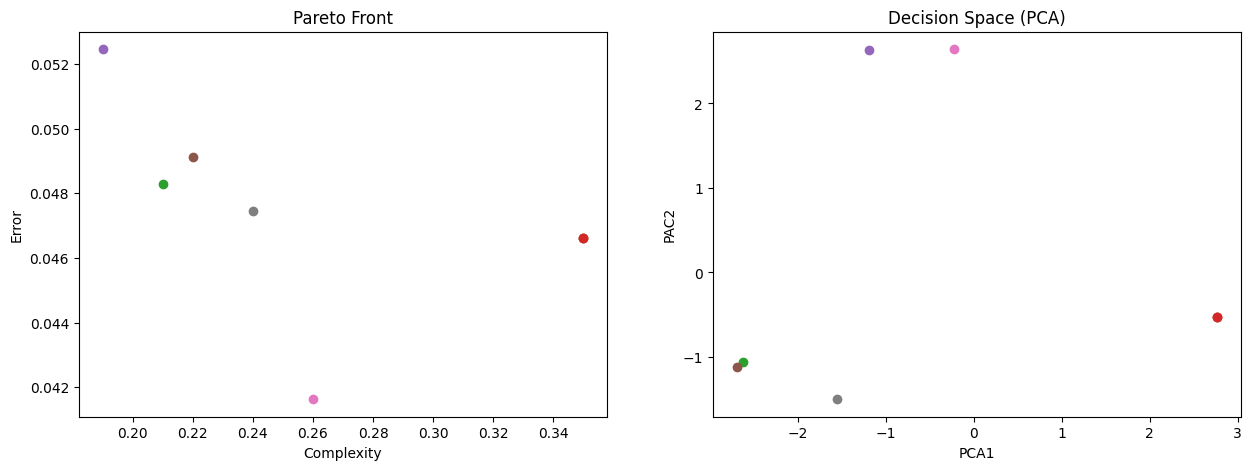

In [112]:
fig, axs = plt.subplots(1,2, figsize=(15,5))

X_2d = PCA(n_components=2).fit_transform(np.array(decision_space))

for i in range(len(pareto_front)):
    axs[0].scatter(pareto_front[i,0], pareto_front[i,1])
    axs[1].scatter(X_2d[i,0], X_2d[i,1])

axs[0].set_title('Pareto Front')
axs[0].set_xlabel('Complexity')
axs[0].set_ylabel('Error')
axs[1].set_title('Decision Space (PCA)')
axs[1].set_xlabel('PCA1')
axs[1].set_ylabel('PAC2')
plt.show()